In [98]:
import argparse
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab import drive
from google.colab.patches import cv2_imshow

In [99]:
def thin_tick_circle_line(out_circles):
  pixel_threshold = 5
  postprocess_circles = []
  
  for x, y, r, v in out_circles:
    if all(abs(x - xc) > pixel_threshold or abs(y - yc) > pixel_threshold or abs(r - rc) > pixel_threshold for xc, yc, rc, v in postprocess_circles):
      postprocess_circles.append((x, y, r, v))
  
  return postprocess_circles

In [100]:
def get_candidate_circles(thetas, rs_list, num_thetas):
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  
  circle_candidates = []
  for r in rs_list:
    for t in range(num_thetas):
      circle_candidates.append((r, int(r * cos_thetas[t]), int(r * sin_thetas[t])))
  
  return circle_candidates


In [101]:
def get_accumulator_votes_array(img_height, img_width, edge_image, candidated_circles):
  accumulator = defaultdict(int)
  
  for y in range(img_height):
    for x in range(img_width):
      if edge_image[y][x] != 0:
        for r, rcos_t, rsin_t in candidated_circles:
          x_center = x - rcos_t
          y_center = y - rsin_t
          accumulator[(x_center, y_center, r)] += 1
  
  return sorted(accumulator.items(), key=lambda i: -i[1])

In [102]:
def get_out_circles_considering_votes_and_thresholds(accumulator, num_thetas, bin_threshold):
  out_circles = []
  
  for candidate_circle, votes in accumulator:
    x, y, r = candidate_circle
    current_vote_percentage = votes / num_thetas
    if current_vote_percentage >= bin_threshold: 
      out_circles.append((x, y, r, current_vote_percentage))
  
  return out_circles

In [103]:
def find_hough_circles(image, edge_image, num_thetas, bin_threshold):
  img_height, img_width = edge_image.shape[:2]
  dtheta = int(360 / num_thetas)
  thetas = np.arange(0, 360, step=dtheta)
  rs = [57, 71, 38, 17, 35, 59]

  candidated_circles = get_candidate_circles(thetas, rs, num_thetas)
  accumulator = get_accumulator_votes_array(img_height, img_width, edge_image, candidated_circles)
  out_circles = get_out_circles_considering_votes_and_thresholds(accumulator, num_thetas, bin_threshold)
  out_circles = thin_tick_circle_line(out_circles)
  
  output_img = image.copy()
  for x, y, r, v in out_circles:
    output_img = cv2.circle(output_img, (x,y), r, (0,255,0), 2)
  
  return output_img

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


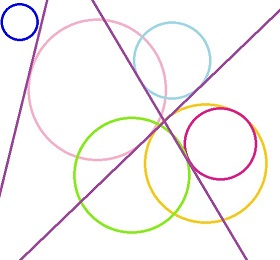

In [104]:
  input_img = cv2.imread("Shapes.jpg")
  cv2_imshow(input_img)

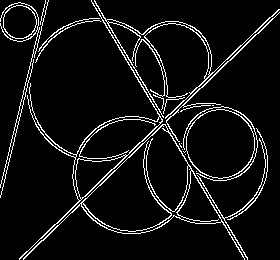

In [105]:
  edge_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
  edge_image = cv2.Canny(edge_image, 100, 200)
  cv2_imshow(edge_image)

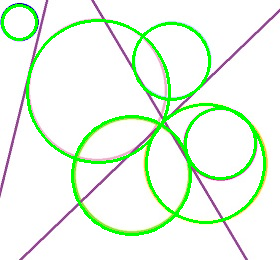

In [111]:
  circle_img = find_hough_circles(input_img, edge_image, 70, 0.4)
  cv2_imshow(circle_img)